# Evolving Ensembles in Multi-objective GeneticProgramming for Classification with Unbalanced Data

#### Dataset YEAST

Minority class = 'MIT'

Majority class = other tags

Number of features = 8, Type = Real

#### Dataset JDT R3 0 & Dataset PDE R3 0

Minority class (bug_cnt) = '0'

Majority class (bug_cnt) = other tags (> 0)

Number of features = 48, Type = Real

In [1]:
# Python 3.8.3
import deap # 1.3.1
from deap import gp, creator, base, tools, algorithms
from deap import benchmarks
from deap.benchmarks.tools import hypervolume

import numpy as np # 1.18.5

import time

import operator, random

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from pandas import read_csv

import seaborn

In [2]:
plt.rcParams['figure.figsize'] = (16,16)

### Parameters

In [3]:
PNUM = 20 #20 # Number of individuals in a population (500)
GNUM = 10 #10 # Number of generations (50) 
MTC = 0.4 # Mutation chance (0.4)
CSC = 0.6 # Crossover chance (0.6)

ATR_DATA = 8 #Data set atributes

EPS = 0.1 # Range for protected division

#### Helper functions for primitive operators

In [4]:
# Protected division
def div(x, y): 
    if(y < EPS and y > -EPS): return 0
    return x/y

# If then operator - changed the name from 'if_then' to 'lf' because of cxSemantic method
def lf(a, b, c):
    return b if (a < 0) else c

#### Importing dataset

In [5]:
#filename = "./Datasets/yeast_csv.csv"
filename = "./Datasets/JDT_R3_0.csv"

# X = inputs, y = outputs

if "yeast" in filename:
    dataframe = read_csv(filename, header=None)
    data = dataframe.values
    X, y = data[:, :-1], data[:, -1]
    print(X.shape)
    print(y.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)
else:
    dataframe = read_csv(filename, header=0)
    ATR_DATA = 48 
    data = dataframe.values
    X, y = data[:, 1:-1], data[:, -1]
    print(X.shape)
    print(y.shape)
    for i in range(len(y)):
        if y[i] != 0: y[i] = 1
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
              
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

data = X_train.tolist()

names = y_train.tolist()
#print(names)
#print(names.count(0))
#print(names.count(1))

(3420, 48)
(3420,)
(1710, 48) (1710, 48) (1710,) (1710,)


#### Creating a primitive set for the classificator expression

In [6]:
pset = gp.PrimitiveSet("main", arity=ATR_DATA)

# Adding primitive operators
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(div, 2) 
pset.addPrimitive(lf, 3, name="lf") # Added 'lf' as a name for the function


# Generate an expression where each leaf has the same depth between min and max.
expr = gp.genHalfAndHalf(pset, min_=1, max_=8) # Create expression of max depth 8 (from paper)
tree = gp.PrimitiveTree(expr) # Create tree classificator from expression

### Creating a fitness function and an individual (Generation of Tree Individuals)

In [7]:
creator.create("FitnessMax", base.Fitness, weights=(1.0, 1.0)) #FitnessMax, Multi, Min?

# Create an individual of type primitive tree and our fitness function, pset is a previously defined
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax, pset=pset)

### Helper function for evaluation

In [8]:
# Evaluation function
def evaluateAccuracy(individual, data, names, pset): # po predlosku
    
    #Compiling the expression
    classificator = gp.compile(individual, pset)
    
    if "yeast" in filename:
        minority_count = names.count("MIT")
    else:
        minority_count = names.count(0)
        
    true_positive_count = 0

    majority_count = len(names) - minority_count
    true_negative_count = 0

    for (d, n) in zip(data, names):
        # feeding data to individual classificator
        result = classificator(*d)        
        #counting right answers
        if "yeast" in filename:
            if (n=="MIT") and (result >= 0): true_positive_count += 1
            elif (n!="MIT") and (result < 0): true_negative_count += 1
        else:
            if (n==0) and (result >= 0): true_positive_count += 1
            elif (n!=0) and (result < 0): true_negative_count += 1
        
    # return accuracy on minority class and majority class
    return (true_positive_count/minority_count, true_negative_count/majority_count)

In [9]:
# Penalty function
def feasible(individual, data, names, pset):
    classificator = gp.compile(individual, pset)
    for (d, n) in zip(data, names):
        result = classificator(*d)
        if (n == "MIT"): return True
    return False

### Registering elements with toolbox

In [10]:
# Creating toolbox - https://deap.readthedocs.io/en/master/examples/gp_symbreg.html
# https://deap.readthedocs.io/en/master/tutorials/basic/part2.html
toolbox = base.Toolbox()

toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=8) # genHalfAndHalf - Generate an expression with a PrimitiveSet pset. Half the time, the expression is generated with genGrow(), the other half, the expression is generated with genFull()
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr) # Register individual from expression

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register('evaluate', evaluateAccuracy, data=data, names=names, pset=pset)


# Register mate function
toolbox.register('mate', gp.cxOnePoint)
#toolbox.register('mate', gp.cxSemantic, pset=pset, min=1, max=8)

#Register mutate function
toolbox.register('mutate', gp.mutNodeReplacement, pset=pset)
#toolbox.register('mutate', gp.mutSemantic, pset=pset, min=1, max=8)

#Register select function
#toolbox.register('select', tools.selSPEA2)
toolbox.register('select', tools.selNSGA2)




### Generating population

In [11]:
population = toolbox.population(n=PNUM)

fits = toolbox.map(toolbox.evaluate, population)
for fit, ind  in  zip(fits, population):
    ind.fitness.values = fit

#history.update(population)

### Setting stats and pareto front variable

In [12]:
# Diversity function
def similarFunc(ind1, ind2):
    if not isinstance(ind1, deap.creator.Individual):
        return False
    if not isinstance(ind2, deap.creator.Individual):
        return False
    if ind1 not in pop:
        return False
    if ind2 not in pop:
        return False

    ind1_pos = pop.index(ind1)
    ind2_pos = pop.index(ind2)
   
    if pop[ind1_pos].fitness.crowding_dist <= pop[ind2_pos].fitness.crowding_dist:
        return True
    return False

In [13]:
pf = tools.ParetoFront(similar=similarFunc)
#pf = tools.ParetoFront()

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)


### Evolving the population 

In [14]:
start = time.time()

In [15]:
#za sve vrijednosti
xvalues = []
yvalues = []

# evolution
pop = toolbox.select(population, len(population))
for gen in range(GNUM):
    offspring = algorithms.varAnd(pop, toolbox, cxpb=CSC, mutpb=MTC)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
        
        xvalues.append(ind.fitness.values[0])
        yvalues.append(ind.fitness.values[1])        
    
    pop = toolbox.select(offspring + pop, k=PNUM)
    pf.update(pop)
    

In [16]:
stop = time.time()
print(f"Training time: {round(stop-start,2)}s")

Training time: 5.04s


### Printing and ploting the results

Hyper:  0.674807130942452


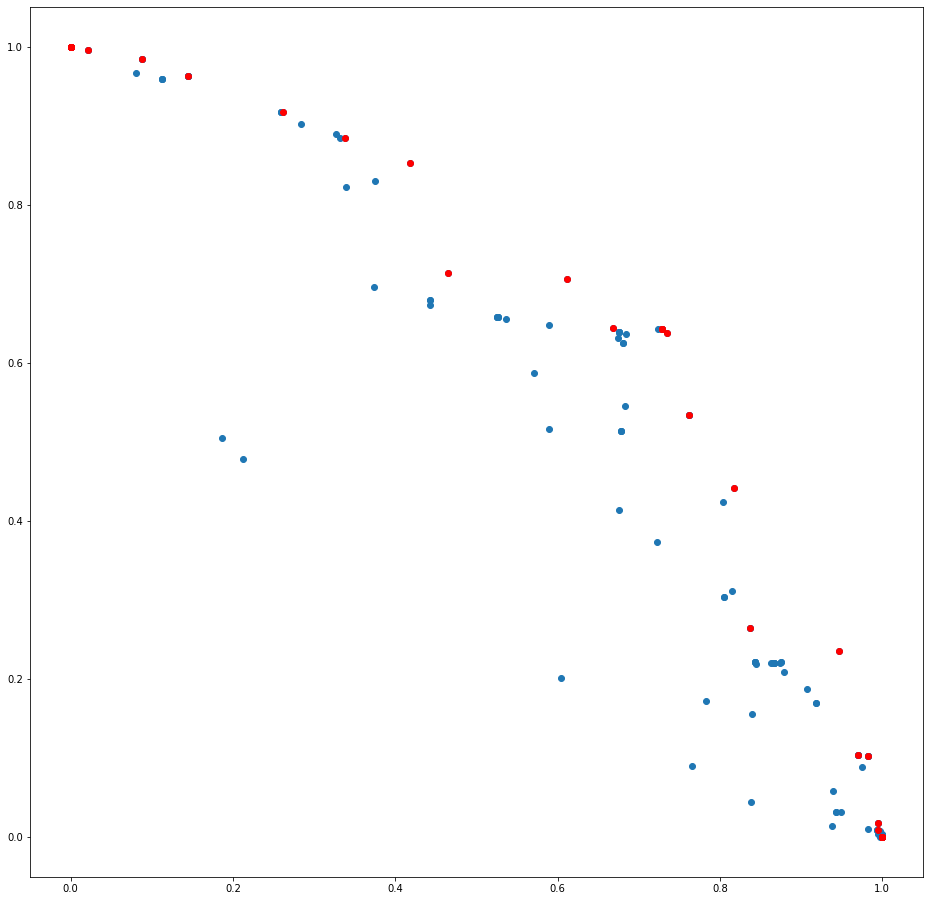

In [17]:
#zapisuje fitness vrijednosti od pareto fronte
px = []
py = []
A = []
for p in pf: 
    px.append(p.fitness.values[0])
    py.append(p.fitness.values[1])    
    A.append((px, py))

hv = hypervolume(pf, [0.0, 0.0])
#hv = tools.indicator.hypervolume(A)
print("Hyper: ", hv)
#hv = hypervolume(A)
    
# plotamo sve fitness vrijednosti i vrijednosti pareto fronte
plt.plot(xvalues, yvalues, 'o') #sve vrijednosti (plava boja)
plt.plot(px, py, 'or') #pareto fronta (crvena boja)
plt.show()



### Testing the population

In [18]:
def testEnsambleAccuracy (data, names, ensamble):
    
    if "yeast" in filename:
        minority_count = np.count_nonzero(names == "MIT")
    else:
        minority_count = np.count_nonzero(names == 0)
        
    true_positive_count = 0
    
    majority_count = len(names) - minority_count
    true_negative_count = 0
    
    for d, n in zip(data, names):
        
        min_vote = 0;
        maj_vote = 0;
        
        for ind in ensamble:
            classificator = gp.compile(ind, pset)
            result = classificator(*d)
            
            if (result > 0): min_vote += 1
            elif (result < 0): maj_vote += 1
                
        if "yeast" in filename:
            if((n == "MIT") and (min_vote > maj_vote)): true_positive_count +=1;
            elif((n != "MIT") and (min_vote <= maj_vote)): true_negative_count += 1;
        else:
            if((n == 0) and (min_vote > maj_vote)): true_positive_count +=1;
            elif((n != 0) and (min_vote <= maj_vote)): true_negative_count += 1;
                
    return (true_positive_count/minority_count, true_negative_count/majority_count)

In [ ]:
print(testEnsambleAccuracy(X_test, y_test, pf))